# Нейросети в задачах обработки текстов. Генерация коротких текстов с помощью Transformer

Барышев Михаил ИУ10-66, Вариант - 5

Цель работы: изучить возможность генерации текстов с помощью нейросетей.

Генерировать тексты можно как с помощью RNN, так и с помощью Transformer, предсказывая следующий символ последовательности по предыдущим. Мы будем использовать архитектуру Transformer.

В этом задании предлагается написать и проучить на небольшом датасете имен генеративную модель на основе символов.

In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

В файле names находится почти 8000 имен на латинице.

Модель будет получать на вход имя Amandy и выдавать его же, только со сдвигом: mandy .

Чтобы сеть училась генерировать заглавные буквы, добавим в начало специальный токен _.

Также нам потребуется правило для останова генерации (это может быть просто ограничение на количество шагов). С другой стороны, можно добавить в конец каждого примера обучающей выборки специальный <EOS> токен. Обозначим его, например, как #:
    
Можно прекращать генерацию при досрочном выпадании <EOS>.

Для генерации на каждом шаге будем подавать на вход букву, предсказанную на предыдущем шаге.

In [2]:
import os
start_token = "_"
eos = '#'

with open("names.txt") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print(f'There are {len(names)} names: ')
for x in names[::1000]:
    print(x)

There are 7578 names: 
_Sharline#
_Leshia#
_Lelah#
_Armando#
_Horace#
_Lenna#
_Sibbie#
_Eleonore#


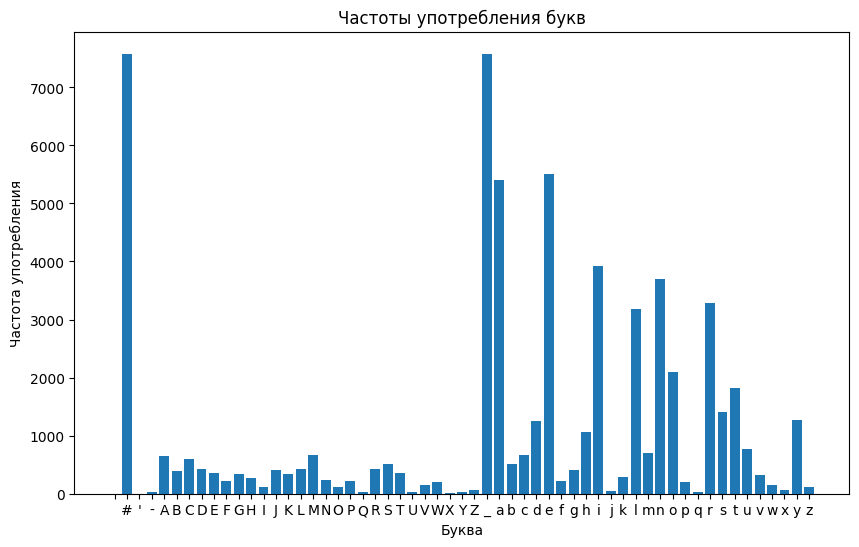

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Создаем список всех букв в именах
letters = [char for name in names for char in name]

# Подсчитываем частоты употреблений букв
letter_counts = Counter(letters)

# Сортируем частоты употреблений по алфавиту
sorted_counts = {k: v for k, v in sorted(letter_counts.items(), key=lambda item: item[0])}

# Получаем отсортированные буквы и их частоты
sorted_letters = list(sorted_counts.keys())
counts = list(sorted_counts.values())

# Строим график
plt.figure(figsize=(10, 6))
plt.bar(sorted_letters, counts)
plt.xlabel('Буква')
plt.ylabel('Частота употребления')
plt.title('Частоты употребления букв')
plt.show()


max length = 17


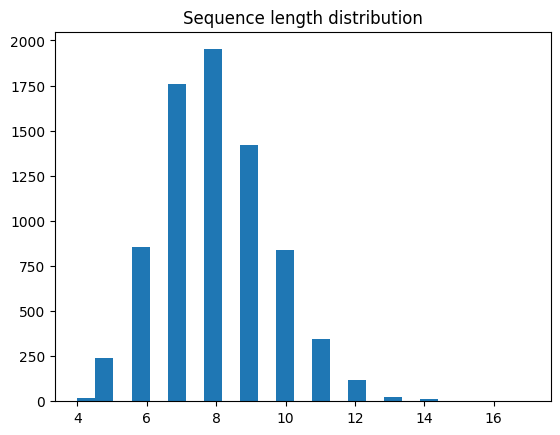

In [4]:
# в датасете есть слова с разными длинами
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [5]:
names[:10]

['_Sharline#',
 '_Cristionna#',
 '_Casper#',
 '_Blinni#',
 '_Joyous#',
 '_Dorene#',
 '_Clemmy#',
 '_Burke#',
 '_Adrianne#',
 '_Humphrey#']

In [6]:
# Получаем уникальные токены из всех имен
tokens = list(set("".join(names)))

# Убеждаемся, что start_token имеет индекс 0
if start_token in tokens:
    tokens.remove(start_token)
tokens.insert(0, start_token)

# Создаем словари для конвертации токенов в индексы и обратно
tok2id = {tok: i for i, tok in enumerate(tokens)}
id2tok = {i: tok for tok, i in tok2id.items()}

n_tokens = len(tokens)
print(f'There are {n_tokens} tokens')

assert 50 < n_tokens < 60

print('Vocabulary: ' + "".join(tokens))


There are 57 tokens
Vocabulary: _zVghCYBdOZpEuecQSXKrnmkLNjT f#M-qPwxGvUA'RDWlIFyasoiHtJb


In [7]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [8]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

_Sharline#
_Cristionna#
_Casper#
_Blinni#
_Joyous#
_Dorene#
_Clemmy#
_Burke#
_Adrianne#
_Humphrey#
[[ 0 17  4 49 20 45 52 21 14 30 28 28]
 [ 0  5 20 52 50 54 52 51 21 21 49 30]
 [ 0  5 49 50 11 14 20 30 28 28 28 28]
 [ 0  7 45 52 21 21 52 30 28 28 28 28]
 [ 0 55 51 48 51 13 50 30 28 28 28 28]
 [ 0 43 51 20 14 21 14 30 28 28 28 28]
 [ 0  5 45 14 22 22 48 30 28 28 28 28]
 [ 0  7 13 20 23 14 30 28 28 28 28 28]
 [ 0 40  8 20 52 49 21 21 14 30 28 28]
 [ 0 53 13 22 11  4 20 14 48 30 28 28]]


In [9]:
from sklearn.model_selection import train_test_split

def split_data(names, test_size=0.2):
    train_names, test_names = train_test_split(names, test_size=test_size, random_state=42)
    return train_names, test_names

train_names, test_names = split_data(names)

print(f'Training set size: {len(train_names)}')
print(f'Test set size: {len(test_names)}')


Training set size: 6062
Test set size: 1516


In [10]:
train_data, val_data = split_data(names)

len(train_data), len(val_data)

(6062, 1516)

## Char-Transformer для имен

Вам нужно написать сеть, кодирующую входные символы и их позиции с помощью таблиц Embeddings. Получившиеся тензоры пропустить через TransformerEncoder, затем преобразовать в логиты для предсказания новых символов.

Transformer может обрабатывать сразу всю последовательность за один проход. Для того, чтобы у модели не было возможности "заглянуть в будущее", то есть использовать информацию о впреди идущих символах, необходимо сгенерировать маску. TransformerEncoder должен принимать на вход последовательность символов и маску.

In [11]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NameTransformer(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=2, n_head=2, dropout=0.1):
        super(NameTransformer, self).__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.encoder_layer = nn.TransformerEncoderLayer(emb_size, n_head, hidden_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, n_layers)
        self.linear = nn.Linear(emb_size, vocab_size)
        self.register_buffer("position_ids", torch.arange(MAX_LENGTH).unsqueeze(1))

    def _generate_square_subsequent_mask(self, seq_len):
        mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
        
    def forward(self, input):
        batch_size = input.size(0)
        mask = self._generate_square_subsequent_mask(input.size(1)).to(input.device)
        input = self.embedding(input)
        input += self.position_ids[:input.size(1), :].unsqueeze(0)
        output = self.transformer_encoder(input.transpose(0, 1), mask=mask)
        output = self.linear(output)
        
        return output


In [13]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        nums = to_matrix(batch)
        input_tensor = torch.tensor(nums, dtype=torch.long, device=device)
        output = model(input_tensor)
        
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output.view(-1, model.vocab_size), input_tensor.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:  
        nums = to_matrix(batch)
        input_tensor = torch.tensor(nums, dtype=torch.long, device=device)
        
        output = model(input_tensor)
        
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output.view(-1, model.vocab_size), input_tensor.view(-1))
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        val_log.append((total_steps, np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)


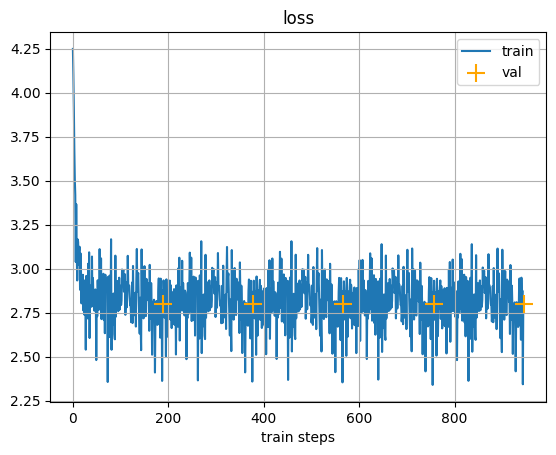

In [14]:
# model = NameTransformer(len(tokens), 64, 64, n_layers=2, n_head=2, dropout=0.1)

# opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# train(model, opt, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NameTransformer(len(tokens), 64, 64, n_layers=2, n_head=2, dropout=0.1).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, 5)


## Генерация по argmax

In [15]:
import torch

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def pick_by_argmax(logits):
    return torch.argmax(logits, dim=-1)

def gen_continuation(model, prefix="_"):
    nums = to_matrix(prefix)
    nums = torch.from_numpy(nums)
    with torch.no_grad():
        outputs = model(nums)
    last_output = outputs[:, -1, :]
    
    output_ids = [torch.argmax(last_output).item()]
    print(f"Initial next token: {output_ids[0]}")
    for _ in range(5):
        with torch.no_grad():
            next_output = model(torch.tensor([output_ids[-1]]).unsqueeze(0))
        next_token_logits = next_output[:, -1, :]
        next_token_prob = torch.softmax(next_token_logits, dim=-1)
        next_token_id = torch.multinomial(next_token_prob, 1).item()
        print(f"Next token: {next_token_id}")
        output_ids.append(next_token_id)
    
    print(prefix + '|' + ids2string(output_ids))

gen_continuation(model, " Ab")




Initial next token: 28
Next token: 54
Next token: 54
Next token: 49
Next token: 49
Next token: 7
 Ab| ttaaB


## Генерация с семплированием

In [16]:
# import torch

# def batch2string(ids, prefix):
#     batch_strings = []
#     for batch_ids in ids:
#         string = ""
#         for id in batch_ids:
#             string += id2tok[id.item()]
#         batch_strings.append(string)
#     return batch_strings

# def pick_by_distribution(logits, temperature=1.0):
#     # Применяем softmax с температурой
#     probabilities = torch.softmax(logits / temperature, dim=-1)
#     # Семплируем из распределения
#     samples = torch.multinomial(probabilities, 1)
#     return samples

# def gen_continuation_temp(model, prefix="_", temperature=1.0, n=10):
#     prefix_tensor = to_matrix([prefix] * n)
#     prefix_tensor = torch.from_numpy(prefix_tensor)

#     # Передаем префикс модели
#     with torch.no_grad():
#         outputs = model(prefix_tensor)
    
#     # Создаем пустую матрицу для хранения сгенерированных токенов
#     output_ids = torch.zeros(n, n, dtype=torch.long)
    
#     # Сгенерируем каждый токен по одному за раз для каждого примера в батче
#     for i in range(n):
#         # Получаем последний output, чтобы получить первое предсказание
#         last_output = outputs[i, -1, :]
#         # Сэмплируем следующий токен с учетом температуры
#         next_token_probs = torch.softmax(last_output / temperature, dim=-1)
#         sampled_id = torch.multinomial(next_token_probs, 1).squeeze().item()
#         output_ids[i, 0] = sampled_id
#         # Генерируем n-1 следующих токенов
#         for j in range(1, n):
#             with torch.no_grad():
#                 next_output = model(output_ids[i, :j].unsqueeze(0))
#             next_token_probs = torch.softmax(next_output[:, -1, :] / temperature, dim=-1)
#             sampled_id = torch.multinomial(next_token_probs, 1).squeeze().item()
#             output_ids[i, j] = sampled_id
    
#     print(batch2string(output_ids, prefix + '|'))

# gen_continuation_temp(model, " Ku", temperature=0.7, n=10)
import torch
import torch.nn.functional as F
import numpy as np

# Пример функции для преобразования индексов в строку (зависит от вашего токенизатора)
def ids2string(ids):
    return "".join([id2char[id] for id in ids])

def batch2string(ids_batch, prefix):
    # Преобразует батч индексов в строки, добавляя префикс к каждой строке
    return [prefix + ids2string(ids) for ids in ids_batch]

def pick_by_distribution(logits, temperature=1.0):
    # Преобразует логиты в вероятности с учетом температуры
    probs = F.softmax(logits / temperature, dim=-1)
    # Семплирует индексы из распределения вероятностей
    sampled_ids = torch.multinomial(probs, num_samples=1)
    return sampled_ids

def to_matrix(strings, max_len=None, pad_char=' '):
    # Преобразует список строк в матрицу индексов токенов
    if max_len is None:
        max_len = max(map(len, strings))
    matrix = np.zeros((len(strings), max_len), dtype=np.int64)
    for i, string in enumerate(strings):
        for j, char in enumerate(string):
            if j >= max_len:
                break
            matrix[i, j] = char2id.get(char, char2id[pad_char])
    return matrix

def gen_continuation_temp(model, prefix="_", temperature=1.0, n=10, max_length=100):
    # Преобразует префикс в матрицу индексов
    nums = to_matrix([prefix] * n)
    nums = torch.from_numpy(nums)

    # Подать префикс на вход модели
    with torch.no_grad():
        outputs = model(nums)
        logits = outputs[:, -1, :]  # Получить логиты для последнего токена

    outs = []
    for _ in range(max_length):
        sampled_ids = pick_by_distribution(logits, temperature)
        outs.append(sampled_ids.squeeze(-1))  # Удалить лишнее измерение
        nums = torch.cat((nums, sampled_ids), dim=1)  # Обновить nums
        with torch.no_grad():
            outputs = model(nums)
            logits = outputs[:, -1, :]  # Обновить логиты для последнего токена

    outs = torch.stack(outs, dim=1).numpy()
    generated_strings = batch2string(outs, prefix)
    for string in generated_strings:
        print(string)

char2id = {'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, ' ': 27}
id2char = {v: k for k, v in char2id.items()}

class SimpleModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SimpleModel, self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embeddings(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

model = SimpleModel(vocab_size=len(char2id), embedding_dim=32, hidden_dim=64)
gen_continuation_temp(model, prefix="_", temperature=1.0, n=10, max_length=20)


_kotmncuroxwm due_hn_
_dh awzghgubyeontakpg
_tytmshhgcguaxuqdjgqx
_krttppqcqlvhezyrdrwu
_vvhjfeimwxxrtjrzrg_o
_aypkdbtsqlnttcaalfns
_kgsdqskvbxm_jzifl_sv
_uxthpenlhxjqjfatsqpc
_ztocbwitdsfgbhvuskbb
_fnxlwljqizdlwjhwaais
